In [18]:
%run ../utils/configuration.ipynb

In [19]:
import sys
import polars as pl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [21]:
df=pd.read_parquet(f'{silver_path}/Telco_customer_churn_model_training.parquet') 

In [22]:
#Yes across all methods
df_1_columns = [
    "number_of_referrals",
    "contract",
    "monthly_charge",
    "age",
    "number_of_dependents",
    "churn_value"
]

df_1 = df[df_1_columns].copy()
df_1.head()

,number_of_referrals,contract,monthly_charge,age,number_of_dependents,churn_value
0,0,1,39.65,78,0,1
1,1,1,80.65,74,1,1
2,0,1,95.45,71,1,1
3,1,1,98.50,78,1,1
4,1,1,76.50,80,1,1


In [23]:
#4 Yes across all methods
df_2_columns = [
    "number_of_referrals",
    "offer",
    "online_security",
    "online_backup",
    "premium_tech_support",
    "contract",
    "payment_method_Mailed Check",
    "monthly_charge",
    "total_charges",
    "total_refunds",
    "total_revenue",
    "age",
    "number_of_dependents",
    "population",
    "churn_value"
]

df_2 = df[df_2_columns].copy()
df_2.head()

,number_of_referrals,offer,online_security,online_backup,premium_tech_support,contract,payment_method_Mailed Check,monthly_charge,total_charges,total_refunds,total_revenue,age,number_of_dependents,population,churn_value
0,0,2,0,0,0,1,0,39.65,39.65,0.0,59.65,78,0,68701,1
1,1,5,0,1,0,1,0,80.65,633.30,0.0,1024.10,74,1,55668,1
2,0,4,0,0,0,1,0,95.45,1752.55,1.0,1910.88,71,1,47534,1
3,1,3,0,1,0,1,0,98.50,2514.50,1.0,2995.07,78,1,27778,1
4,1,3,0,0,0,1,0,76.50,2868.15,0.0,3102.36,80,1,26265,1


In [24]:
#3 Yes across all methods
df_3_columns = [
    "number_of_referrals",
    "offer",
    "phone_service",
    "avg_monthly_long_distance_charges",
    "avg_monthly_gb_download",
    "online_security",
    "online_backup",
    "premium_tech_support",
    "streaming_music",
    "contract",
    "payment_method_Credit Card",
    "payment_method_Mailed Check",
    "monthly_charge",
    "total_charges",
    "total_refunds",
    "total_revenue",
    "age",
    "number_of_dependents",
    "population",
    "churn_value"
]

df_3 = df[df_3_columns].copy()
df_3.head()

,number_of_referrals,offer,phone_service,avg_monthly_long_distance_charges,avg_monthly_gb_download,online_security,online_backup,premium_tech_support,streaming_music,contract,payment_method_Credit Card,payment_method_Mailed Check,monthly_charge,total_charges,total_refunds,total_revenue,age,number_of_dependents,population,churn_value
0,0,2,0,0.00,8,0,0,0,0,1,0,0,39.65,39.65,0.0,59.65,78,0,68701,1
1,1,5,1,48.85,17,0,1,0,0,1,1,0,80.65,633.30,0.0,1024.10,74,1,55668,1
2,0,4,1,11.33,52,0,0,0,1,1,0,0,95.45,1752.55,1.0,1910.88,71,1,47534,1
3,1,3,1,19.76,12,0,1,0,0,1,0,0,98.50,2514.50,1.0,2995.07,78,1,27778,1
4,1,3,1,6.33,14,0,0,0,0,1,0,0,76.50,2868.15,0.0,3102.36,80,1,26265,1


In [25]:
def select_best_models(data, model):
    skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)
    X = data.drop('churn_value', axis = 1)
    y = data['churn_value'].copy()

    train_results,val_results = [],[]
    # perform the cross-validation
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # scale the data
        X_train = apply_scale(X_train)
        X_val = apply_scale(X_val)

        # apply model
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)

        train_results.append((y_train, predictions_train))
        val_results.append((y_val, predictions_val))
    return train_results, val_results

def apply_score(train_results, val_results, score):
    score_train, score_val = [],[]

    for reference, prediction in train_results:
        score_train.append(score(reference, prediction))

    for reference, prediction in val_results:
        score_val.append(score(reference, prediction))
    # print(score_train)
    # print(score_val)
    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),4)
    std_val = round(np.std(score_val),4)

    return avg_train, std_train, avg_val, std_val

def show_results(df, data, score,*args):
    count = 0
    # for each instance of model passed as argument
    for arg in args:
        train_results, val_results  = select_best_models(data, arg)
        avg_train, std_train, avg_val, std_val = apply_score(train_results, val_results, score)#)#)
        # store the results in the right row
        df.iloc[count] = str(avg_train) + '+/-' + str(std_train), str(avg_val) + '+/-' + str(std_val)
        count+=1
    return df

In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [27]:
model_NN = MLPClassifier(max_iter = 2000, random_state = 99)

In [28]:
def apply_scale(dataframe):
    scaler = MinMaxScaler().fit(dataframe)
    return scaler.transform(dataframe)

In [29]:
df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['KNN'])
print('------------------------------------------')
print('f1_score')
print('------------------------------------------')
display(show_results(df_all, df_1,f1_score, model_NN))
print('precision_score')
print('------------------------------------------')
display(show_results(df_all, df_1,precision_score, model_NN))

------------------------------------------
f1_score
------------------------------------------


,Train,Validation
KNN,0.643+/-0.0074,0.638+/-0.0245


precision_score
------------------------------------------


,Train,Validation
KNN,0.67+/-0.0107,0.665+/-0.0082


In [30]:
df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['KNN'])
print('------------------------------------------')
print('f1_score')
print('------------------------------------------')
display(show_results(df_all, df_2,f1_score, model_NN))
print('precision_score')
print('------------------------------------------')
display(show_results(df_all, df_2,precision_score, model_NN))

------------------------------------------
f1_score
------------------------------------------


,Train,Validation
KNN,0.723+/-0.0092,0.68+/-0.0164


precision_score
------------------------------------------


,Train,Validation
KNN,0.765+/-0.0119,0.719+/-0.0124


In [31]:
df_all = pd.DataFrame(columns = ['Train','Validation'], index = ['KNN'])
print('------------------------------------------')
print('f1_score')
print('------------------------------------------')
display(show_results(df_all, df_3,f1_score, model_NN))
print('precision_score')
print('------------------------------------------')
display(show_results(df_all, df_3,precision_score, model_NN))

------------------------------------------
f1_score
------------------------------------------


,Train,Validation
KNN,0.759+/-0.0171,0.675+/-0.0155


precision_score
------------------------------------------


,Train,Validation
KNN,0.81+/-0.0153,0.722+/-0.0216


Model Optimization

In [33]:
def point_plot(train, validation, values_try):
    sns.pointplot(x=values_try, y=train, color = 'teal', label = 'Train')
    sns.pointplot(x=values_try, y=validation, color = 'goldenrod', label = 'Validation')
    plt.legend()

In [34]:
def get_models_nn(data, values):
    models = dict()
    results_train, results_val, names = [],[],[]

    # create the instances of each model with different values
    for value in values:
        models[str(value)] = MLPClassifier(hidden_layer_sizes = value, max_iter = 2000, random_state = 99)

    for name, model in models.items():
        train_results, val_results  = select_best_models(data, model)
        avg_train, std_train, avg_val, std_val = apply_score(train_results, val_results, f1_score)
        results_train.append(avg_train)
        results_val.append(avg_val)
        names.append(name)

    return results_train, results_val, names

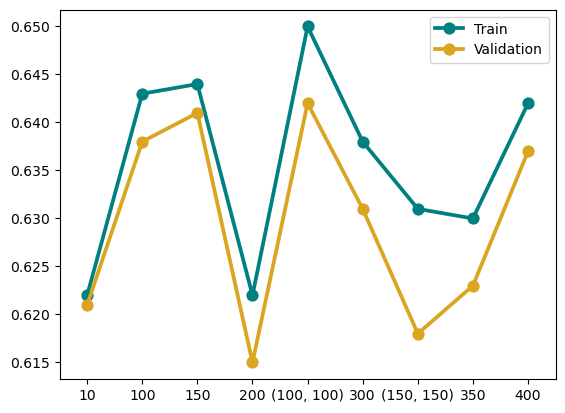

In [35]:
values_try = [(10),(100),(150),(200),(100,100),(300),(150,150),(350),(400)]
results_train, results_val, names = get_models_nn(df_1, values_try)
point_plot(results_train, results_val, names)

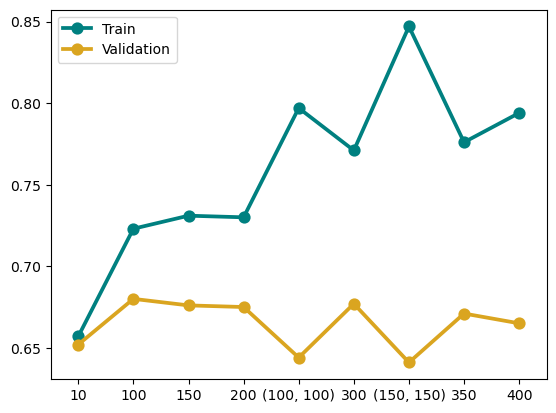

In [36]:
values_try = [(10),(100),(150),(200),(100,100),(300),(150,150),(350),(400)]
results_train, results_val, names = get_models_nn(df_2, values_try)
point_plot(results_train, results_val, names)

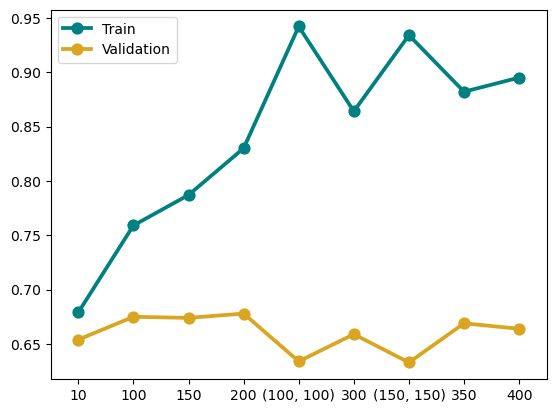

In [37]:
values_try = [(10),(100),(150),(200),(100,100),(300),(150,150),(350),(400)]
results_train, results_val, names = get_models_nn(df_3, values_try)
point_plot(results_train, results_val, names)

GridSearch

In [ ]:
data = df.copy()

X_data = data.drop(['churn_value'], axis = 1)
y_data = data['churn_value'].copy()

X_data = encoding_and_dummy(X_data)
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

In [ ]:
# DO IT
nn = MLPClassifier(max_iter = 2000, random_state = 99)

In [ ]:
parameter_space_random = {
    'hidden_layer_sizes': [(280),(290),(300),(310),(320)],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling','adaptive'],
    'solver': ['sgd','adam'],
    'activation': ['logistic','relu']
}

In [ ]:
# DO IT
random_search = RandomizedSearchCV(nn, param_distributions=parameter_space_random,
                                   scoring='f1', cv=5, random_state=99)

In [ ]:
random_search.fit(X_data, y_data)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

GridSearch

In [ ]:
parameter_space_grid = {
    'hidden_layer_sizes': [(280)],
    'learning_rate_init': [0.01, 0.005, 0.015],
    'learning_rate': ['constant'],
    'solver': ['sgd','adam'],
    'activation': ['relu']
    }

In [ ]:
# DO IT
grid_search = GridSearchCV(nn, parameter_space_grid, scoring='f1', return_train_score=True, cv=5)

In [ ]:
grid_search.fit(X_data, y_data)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

In [ ]:
final_model_nn = MLPClassifier(activation = 'relu',
                               hidden_layer_sizes = (280),
                               learning_rate = 'constant',
                               learning_rate_init = 0.015,
                               solver = 'adam', max_iter = 2000, random_state = 99)